# EM For Linear Mixed Model#

Author: Smooth  
Date: 2018.10.30

## The model
The basic model is $y=Xu+e$  
Where $u\thicksim N(0,\sigma_u^2I_{m\times m}), e\thicksim N(0,\sigma_e^2I_{n\times n})$

### Log Likelihood

\begin{equation}
\begin{aligned}
L(y,u|\theta)&=\prod_{i=1}^np(y_i,u)\\
&=\prod_{i=1}^np(y_i|u)p(u)\\
&=\prod_{i=1}^np(y_i|u)\prod_{j=1}^mp(u_j)\\
&=\prod_{i=1}^n\frac{1}{\sqrt{2\pi}\sigma_e}exp(-\frac{(y_i-x_{i.}u)^2}{\sigma_{e}^{2}})\prod_{j=1}^m\frac{1}{\sqrt{2\pi}\sigma_u}exp(-\frac{u_j^2}{\sigma_{u}^{2}})\\
&=(\sqrt{2\pi}\sigma_e)^{-n}exp(-\frac{1}{\sigma_{e}^{2}}\sum_{i=1}^n{(y_i-x_{i.}u)^2})(\sqrt{2\pi}\sigma_u)^{-p}exp(-\frac{1}{\sigma_{u}^{2}}\sum_{j=1}^m{u_j^2})\\
\\
l(y,u|\theta)&=logL(y,u|\theta)=-\frac{n}{2}log\sigma_e^2-\frac{m}{2}log\sigma_u^2-\frac{1}{2\sigma_e^2}r^Tr-\frac{1}{2\sigma_u^2}u^Tu
\end{aligned}
\end{equation}

### EM Algorithm
$\circ$ The calculation for M-step  ($\sigma_e^2,\sigma_u^2$)
\begin{equation}
\begin{aligned}
E(l(y,u)|y,\theta)&=E(-\frac{n}{2}log\sigma_e^2-\frac{m}{2}log\sigma_u^2-\frac{1}{2\sigma_e^2}r^Tr-\frac{1}
{2\sigma_u^2}u^Tu|y,\theta)\\
\\
\frac{\partial E(l(y,u)|y,\theta)}{\partial \sigma_e^2}&=E(-\frac{n}{2\sigma_e^2}+\frac{r^Tr}{2\sigma_e^4}|y,\theta)\\
\\
\frac{\partial E(l(y,u)|y,\theta))}{\partial \sigma_u^2}&=E(-\frac{m}{2\sigma_u^2}+\frac{u^Tu}{2\sigma_u^4}|y,\theta)\\
\\
\sigma_e^2&=\frac{E(r^Tr|y,\theta)}{n}\\
\\
\sigma_u^2&=\frac{E(u^Tu|y,\theta)}{m}
\end{aligned}
\end{equation}


$\circ$ The calculation for E-step  ($E(u^Tu|y,\theta),E(r^Tr|y,\theta)$)
\begin{equation}
\begin{aligned}
u&\thicksim N(0,\sigma_u^2I),e\thicksim N(0,\sigma_e^2I)\\
y|u&\thicksim N(Xu,\sigma_e^2I)\\
y|e&\thicksim N(0, X\sigma_u^2IX^T)\\
\end{aligned}
\end{equation}  

$\bullet$ The calculation for $E(u^Tu|y,\theta)$
\begin{equation}
\begin{aligned}
p(u)&=\mathcal N(u|e,\sigma_u^2I)\\
p(y|u)&=\mathcal N(y|Xu,\sigma_e^2I)\\
\\
iU&=(\sigma_u^2I)^{-1}\\
iV&=(\sigma_e^2I)^{-1}\\
A&=(iU+X^TiVX)^{-1}\\
\\
p(y)&=\mathcal N(y|0,\sigma_e^2I+X\sigma_u^2IX^T)\\
p(u|y)&=\mathcal N(u|A(X^TiVy),A)\\
\\
E(u^Tu|y,\theta)&=E(u|y,\theta)^TE(u|y,\theta)+Var(u|y,\theta)=(X^TiVy)^TA^TA(X^TiVy)+trace(A)
\end{aligned}
\end{equation}

$\bullet$ The calculation for $E(r^Tr|y,\theta)$
\begin{equation}
\begin{aligned}
&E(r^Tr|y,\theta)\\
=&E((y-Xu)^T(y-Xu)|y,\theta)\\
=&E(y^Ty-2y^TXu+u^TX^TXu|y,\theta)\\
=&y^Ty-2y^TXE(u|y,\theta)+E(u^TX^TXu|y,\theta)\\
=&y^Ty-2y^TXA(X^TiVy)+E(trace(Xuu^TX^T)|y,\theta)\\
=&y^Ty-2y^TXA(X^TiVy)+E(trace(X^TXuu^T)|y,\theta)\\
=&y^Ty-2y^TXA(X^TiVy)+trace(X^TXE(uu^T|y,\theta))\\
=&y^Ty-2y^TXA(X^TiVy)+trace(X^TX(X^TiVy)^TA^TA(X^TiVy)+trace(A)))
\end{aligned}
\end{equation}

### The Algorithm -- EM for LMM
![hello em](https://github.com/SmoothL/EM-for-LMM/blob/master/Algorithm.png?raw=true)

## The code

In [7]:
__author__ = 'Smooth'

import numpy as np
from numpy.linalg import *
import matplotlib.pyplot as plt

In [8]:
def em_lmm(obj):
    X = obj['X']
    eps = obj['eps']

    logl = -np.inf
    [n, m] = X.shape
    y = obj['y'].reshape([n, 1])
    u = np.zeros([m, 1])
    Su = obj['Su']
    Se = obj['Se']
    
    def loglikehood(y,X,u,Se,Su,n,m):
        r = y - np.dot(X,u)
        loglikehood = -0.5*n*np.log(2*Se)-0.5*m*np.log(Su)-0.5*np.dot(r.T,r)/Se-0.5*np.dot(u.T,u)/Su
        return loglikehood[0,0]
    
    plogl = loglikehood(y,X,u,Se,Su,n,m)
    print(plogl)
    plogll = []
    plogll.append(plogl)
    
    
    while (abs(plogl-logl)) > eps:
        logl = plogl
        #E-Step
        iU = inv(Su*np.identity(m))
        iV = inv(Se*np.identity(n))
        A = inv(iU+np.dot(np.dot(X.T,iV),X))
        mu_u = np.dot(A,np.dot(X.T,np.dot(iV,y)))
        uTu = np.dot(mu_u.T,mu_u)+np.trace(A)
        
        rr = y-np.dot(X,mu_u)
        rTr = np.dot(rr.T,rr)+np.trace(np.dot(np.dot(X.T,X),A))
        
#         Z = X
#         ZZt = np.dot(Z,Z.T)
#         V = ZZt * Su + Se
#         iV = inv(V)
#         uTu = Su * Su * (np.dot(np.dot(np.dot(np.dot(y.T, iV), ZZt), iV), y)) + np.trace(
#                 Su - Su * Su * (np.dot(np.dot(Z.T, iV), Z)))
#         eTe = Se * Se * (np.dot(np.dot(np.dot(y.T, iV), iV), y)) + np.trace(Se - Se * Se * (iV))
        
        #M-Step
        Su = uTu/m
        Se = rTr/n
        
        plogl = loglikehood(y,X,u,Se,Su,n,m)
        plogll.append(plogl)
        
    return plogll
        

-10017158.012457445
[-10017158.012457445, -2759.5510917327356, -2725.3076938427757, -2724.4891478991403, -2724.469170322696]


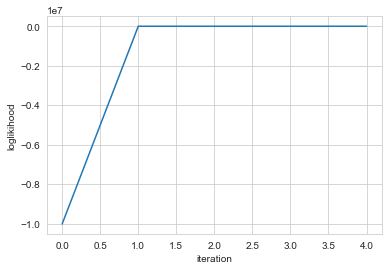

In [15]:
if __name__ == '__main__':
    sampleNo = 200
    mu = 1000
    sigma = 10
    y = sigma * np.random.randn(sampleNo ) + mu
    
    X = np.random.rand(sampleNo,5)
    
    object = {}
    object['X'] = X
    object['y'] = y
    object['eps'] = 1e-1
    object['Su'] = 10
    object['Se'] = 10
    
    plogl = em_lmm(object)
    print(plogl)
    plt.figure()
    plt.plot(plogl)
    plt.xlabel("iteration")
    plt.ylabel("loglikihood")
    plt.show()

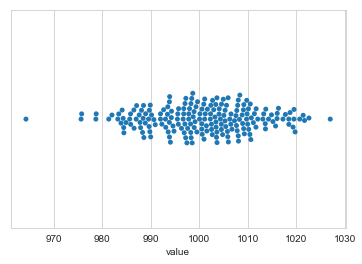

In [16]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure()
# sns.distplot(y, bins=20, kde=True,rug=True) 
# plt.xlabel("value")
# plt.ylabel("frequency")
# plt.show()
# plt.figure()
sns.swarmplot(x=y)
plt.xlabel("value")
plt.show()